In [1]:
import dataset
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
#download spacy english and restart kernel when loading the first time
#!python -m spacy download en_core_web_lg

In [3]:
data_location = "../dataset"

In [4]:
#define the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [5]:
#testing the dataset class
flickr_dataset =  dataset.FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)


In [6]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

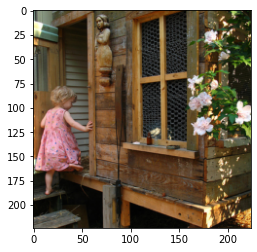

Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [7]:
img, caps = flickr_dataset[0]
show_image(img)
print("Token:",caps)
print("Sentence:")
print([flickr_dataset.vocab.itos[token] for token in caps.tolist()])

### Training

In [8]:
from lstm_base import BaseLSTM

In [9]:
model = BaseLSTM(300, 200, flickr_dataset.vocab)

In [10]:
lengths = (torch.Tensor([0.6, 0.2, 0.2])*len(flickr_dataset)).int()

In [11]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset = flickr_dataset, lengths = lengths)

In [12]:
BATCH_SIZE = 32
NUM_WORKER = 1

#token to represent the padding
pad_idx = flickr_dataset.vocab.stoi["<PAD>"]




train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=dataset.CapsCollate(pad_idx=pad_idx,batch_first=True)
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=dataset.CapsCollate(pad_idx=pad_idx,batch_first=True)
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=dataset.CapsCollate(pad_idx=pad_idx,batch_first=True)
)


In [13]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# See this for input references - https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu
# A Caption should be a list of strings.
# Reference Captions are list of actual captions - list(list(str))
# Predicted Caption is the string caption based on your model's output - list(str)
# Make sure to process your captions before evaluating bleu scores -
# Converting to lower case, Removing tokens like <start>, <end>, padding etc.

def bleu1(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)


def bleu4(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)

In [14]:
_ = model.train()

In [ ]:
LEARNING_RATE = 1e-5
EPOCHS = 30


training_loss = []
valid_loss = []
#valid_bleu1 = []
#valid_bleu4 = []

best_valid_loss = 100 # large number for base iteration

terminate_count = 5 # after 5 continuous worse validation loss, terminate training

if __name__ == "__main__": 
    device = torch.device("cuda")
    print(torch.cuda.memory_allocated(device))
    # to cuda device
    model = model.to(device)
    print(torch.cuda.memory_allocated(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for i in range(EPOCHS):
        for idx, (imgs, caps) in enumerate(tqdm(train_loader)):
            #if len(imgs) > 1:
            optimizer.zero_grad()
            model.encoder.zero_grad()
            model.decoder.zero_grad()
            imgs, caps = imgs.to(device), caps.to(device)

            #targets = pack_padded_sequence(caps, lens, batch_first=True, enforce_sorted=False)[0]


            out = model(imgs, caps)
            loss = criterion(out.view(-1, len(flickr_dataset.vocab)) , caps.view(-1))
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())


            #if (idx+1)%50 == 0:
            #    print("loss: {:.5f}".format(loss.item()))

        # evaluate on validation set
        

        model.eval()
        #bleu1_avg = 0
        #bleu4_avg = 0
        loss_avg = 0
        with torch.no_grad():
            for idx, (imgs, caps) in enumerate(tqdm(val_loader)):
                imgs, caps = imgs.to(device), caps.to(device)
                out = model(imgs, caps)
                loss_avg += criterion(out.view(-1, len(flickr_dataset.vocab)) , caps.view(-1)).item()
                #pred = model(imgs)
                
                
                #ref_text = [flickr_dataset.vocab.itos[token] for token in caps.squeeze(0).cpu().numpy()]
                #pred_text = [flickr_dataset.vocab.itos[token] for token in pred.numpy()]

                #bleu1_avg += bleu1([ref_text], pred_text)
                #bleu4_avg += bleu4([ref_text], pred_text)



        
        
        
        #show_image(imgs[0].cpu())
        #print("Prediction:")
        #print(' '.join(pred_text))
        #print("Reference:")
        #print(" ".join(ref_text))
        #print("BLEU1:")
        #print(bleu1([ref_text], pred_text))

        #bleu1_avg /= (idx+1)
        #bleu4_avg /= (idx+1)
        loss_avg /= idx+1
        
        if loss_avg < best_valid_loss:
            best_valid_loss = loss_avg
            torch.save(model.state_dict(), 'models/base_lstm.pth')
            terminate_count = 5
        else:
            terminate_count -= 1
            if terminate_count == 0:
                break
        
        #print("Validation BLEU1: ")
        #print(bleu1_avg)
        print("Validation Loss: ")
        print(loss_avg)
        
        valid_loss.append(loss_avg)
        #valid_bleu1.append(bleu1_avg)
        #valid_bleu4.append(bleu4_avg)
            
        model.train()

0
245315584


  0%|          | 0/759 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 39%|███▉      | 295/759 [01:55<02:52,  2.69it/s]

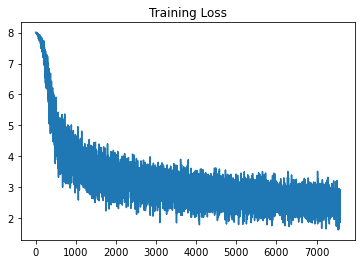

In [48]:
plt.plot(training_loss)
plt.title('Training Loss')
plt.show()

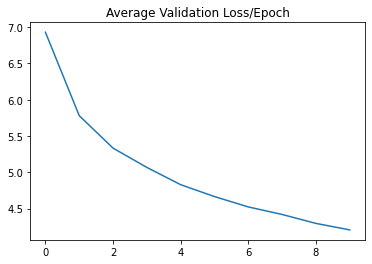

In [53]:
plt.plot(valid_loss)
plt.title('Average Validation Loss/Epoch')
plt.show()

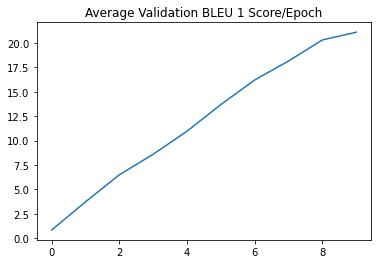

In [55]:
plt.plot(valid_bleu1)
plt.title('Average Validation BLEU 1 Score/Epoch')
plt.show()

In [57]:
import numpy as np

In [61]:
with open('training_loss.npy', 'wb') as f:
    np.save(f, training_loss)

In [63]:
with open('valid_loss.npy', 'wb') as f:
    np.save(f, valid_loss)

In [64]:
with open('valid_bleu1.npy', 'wb') as f:
    np.save(f, valid_bleu1)

In [65]:
with open('valid_bleu4.npy', 'wb') as f:
    np.save(f, valid_bleu4)

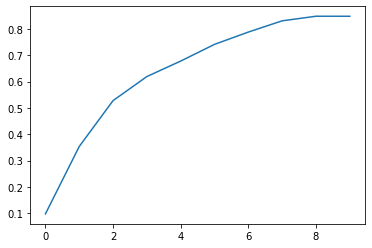

In [45]:
plt.plot(valid_bleu4)

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [66]:

bleu1_avg = 0
bleu4_avg = 0
model.eval()
with torch.no_grad():
    for idx, (imgs, caps) in enumerate(tqdm(test_loader)):
        output = model(img[None, :].to(device))
        ref_text = [flickr_dataset.vocab.itos[token] for token in caps.squeeze(0).numpy()]
        pred_text = [flickr_dataset.vocab.itos[token] for token in output.numpy()]

        bleu1_avg += bleu1([ref_text], pred_text)
        bleu4_avg += bleu4([ref_text], pred_text)


        if (idx+1)%400 == 0:
            show_image(imgs[0])
            print("Prediction:")
            print(' '.join(pred_text))
            print("Reference:")
            print(" ".join(ref_text))
            print("BLEU1:")
            print(bleu1([ref_text], pred_text))

bleu1_avg /= (idx+1)
bleu4_avg /= (idx+1)

  0%|          | 0/8091 [00:00<?, ?it/s]


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [274]:
bleu1_avg

28.55040714059861

In [275]:
bleu4_avg

1.156486732032162

In [321]:
from transformers import BertConfig, ViTConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

# Initializing a ViT & BERT style configuration
config_encoder = ViTConfig()
config_decoder = BertConfig()

config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

# Initializing a ViTBert model from a ViT & bert-base-uncased style configurations
model = VisionEncoderDecoderModel(config=config)

# Accessing the model configuration
config_encoder = model.config.encoder
config_decoder = model.config.decoder
# set decoder config to causal lm
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

# Saving the model, including its configuration
model.save_pretrained("my-model")

# loading model and config from pretrained folder
encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("my-model")
model = VisionEncoderDecoderModel.from_pretrained("my-model", config=encoder_decoder_config)

In [330]:
tokenizer =  AutoTokenizer.from_pretrained('bert-large-uncased')

BertConfig {
  "add_cross_attention": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id

In [329]:
model.generate(pixel_values = imgs)

ValueError: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.